## NLP Project Using Enron Email Dataset

Dataset: https://www.cs.cmu.edu/~./enron/ (May 7 2015 version)

The dataset 'maildir' referenced above must be downloaded into the same directory as the 'NLP Project Using Enron Emails Dataset.ipynb' notebook.

In this notebook I will detail my steps to perform NLP tasks from the starting point of an unstructured dataset containing raw text in the form of emails.

The hypothesis for the final classifier is as follows:

It is possible that the tone of emails changes depending on the relationship between the senders and receivers. Specifically, you might expect emails sent externally (e.g. to clients) would be written in a more formal way than emails sent internally to colleagues who know each other well. The main aim of this notebook is to build a classifier, using deep learning, capable of predicting whether an email was sent internally or not from an extract of the email text-body.

This was chosen as a single example to highlight the kinds of powerful insights that a company may be able to find within their staff emails. From this example, a company who wishes to ensure a culture of consistent professionalism from all employees, even when talking internally, could use the classifier to flag employees who are overly informal when sending emails to external persons (indicated low specificity) or internally (indicated by high sensitivity). This would work by passing a sample of an individual employee's emails through the classifier to find their personal scores.

A binary classifier of internally (only) vs externally viewed emails was created using an RNN which achieved a test accuracy of 0.97.

### Contents:

- <b>Section 1:</b> Import, Process and Clean Data
    - Generate Pandas DataFrame from raw files and extracting potential features (email address, timestamp etc)
    - Clean Text
    - Pad Text
    - Stem Text
    
    I wanted  a single body of clean text associated with each email to train and validate the classifier. The subject of each email was added to the start of the email-body, and each body of text was padded at a character limit to improve consistency of data and make processing more efficient. Padded sections can be treated as a sample of the text and should still hold useful insights into writing style of the author. The text was then stemmed using the NLTK Snowball Stemmer.


- <b>Section 2:</b> Named Entity Recognition


    This is not used for the final model, but is a technique that I had not used before so wanted to try it. Note: carried out on version of text before stemming.
- <b>Section 3:</b> Getting Labels

    The problem will be treated as a binary classifier (Labels: Internal Email(1), External Email(0)) where any email sent to email address through 'To', 'Cc', or 'Bcc' that contains a domain name that doesn't include the string 'enron' will be considered and external email.


- <b>Section 4:</b> Building Classifiers and Analysis
    - Preparing data for neural network
    - Building recurrent neural network
    - Evaluating model


- <b>Section 5:</b> Conclusions

    Overall, I am very pleased with the results of this project and what I have learnt about NLP along the way. Final model had a test accuracy of 0.97 and f1 score of 0.98.
    
    
- <b>Section 6:</b> Save Model

In [64]:
import os
import re
import operator
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf
import string
from string import digits
import re
import spacy
from spacy import displacy
from collections import Counter
from nltk.corpus import stopwords
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, Input
from keras import metrics
from tensorflow.keras.models import model_from_json
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import en_core_web_sm
nlp = en_core_web_sm.load()
cached_StopWords = stopwords.words('english')
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language='english')
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud

## Section 1: Import, Process and Clean Data

### Functions to Navigate File Structure and Parse Text

In [2]:
def parse_text(directory):
    '''Taking the path of the targeted file as the input, this function extracts the metadata and text body from each\
    email and returns a structured list.'''
    split_directory = directory.split('/')
    user = split_directory[1]
    folder = ''.join(split_directory[2:-1])
    
    meta={'Dat':(6,-1,0), 'Fro':(6,-1,1), 'To:':(4,-1,2), 'Sub':(9,-1,3), 'Cc:':(4,-1,4), 'Bcc':(5,-1,5), 'X-F':(8,-1,6),\
          'X-T':(6,-1,7), 'X-c':(6,-1,8), 'X-b':(7,-1,9)}
    
    temp_list = [''] * 13
    
    try:
        mode = 'meta'
        text_body = ''
        f = open(directory)
        for line in f.readlines():
            if mode == 'meta':
                line_start = line[:3]
                if line[:10] == 'X-FileName':
                    mode = 'join'
                    pass
                elif line[:8] == 'X-Folder':
                    pass

                elif line_start in meta:
                    current_position = meta[line_start]
                    temp_list[current_position[2]] = line[current_position[0]:current_position[1]]

            elif mode == 'join':
                text_body = text_body + ' ' + line[:-1]
        temp_list[10] = folder
        temp_list[11] = user
        temp_list[12] = text_body
        return temp_list
    
    except:
        return temp_list

In [3]:
def get_files(input_dir):
    '''Takes a directory string as its input and recursively finds all files at a lower level and applies the\
    parse_text function to them. The output is a list of lists where each list is the output from the parse_text\
    function.'''
    output = []
    
    for entry in os.listdir(input_dir):    
        new_dir = input_dir + '/' + entry
        if os.path.isdir(new_dir) == True:
            _lists = get_files(new_dir)
            for _list in _lists:
                output.append(_list)          
        else:
            output.append(parse_text(new_dir))

    return output

In [4]:
user_list = os.listdir('maildir')
user_list.remove('.DS_Store')
column_names = ['Date', 'From (@)', 'To (@)', 'Subject', 'Cc (@)', 'Bcc (@)', 'From', 'To', 'Cc', 'Bcc',\
                    'Folder', 'User', 'Text_body']
df = pd.DataFrame(columns = column_names)

In [5]:
print('Import of data has started. This may be a short wait.')
for user in user_list:
    df_user = pd.DataFrame(get_files('maildir'+'/'+user), columns=column_names)
    df = pd.concat([df,df_user], ignore_index=True)
    df_user=''
print('Import of data Complete.')

Import of data has started. This may be a short wait.
Import of data Complete.


### Cleaning Data

The following steps were taken to clean the text data for use in the later models.


- Removing columns with:
    - Empty strings as text body
    - Invalid email address formats
- Combining subject and body_text columns
- Padding text to character limit
- Cleaning text:
    - Punctuation removal
    - String made all lower-case
    - Removing numbers
    - Removing stopwords
    - Removing single-character words
    - Removing excess spaces
- Snowball Stemmer
- Shuffle and reindex

In [6]:
# clear empty rows and reindex
df = df[df.Text_body != '']
df.index = list(range(len(df)))

In [7]:
# clear rows from invalid email addresses and reindex
def clear_invalid(df,column):
    to_clear=[]
    count=0
    index=0
    for i in df[column]:
        if '@' not in i and i != '':
            count+=1
            to_clear.append(index)
        elif '<' in i:
            count+=1
            to_clear.append(index)

        index+=1
    print('Total number of invalid email addresses is: ' + str(count))
    df=df.drop(to_clear)
    df.index = list(range(len(df)))
    return df

for col in ['To (@)', 'From (@)', 'Cc (@)', 'Bcc (@)']:
    df = clear_invalid(df,col)

Total number of invalid email addresses is: 3163
Total number of invalid email addresses is: 1401
Total number of invalid email addresses is: 730
Total number of invalid email addresses is: 0


In [8]:
# The project requires a single body of text. Add subject to start of text_body
def combine_columns(df, col1, col2):
    new_column = []
    for i, j in zip(df[col1], df[col2]):
        new_column.append(i + ' ' + j)
    df = df.drop(columns=[col1, col2])
    df[col2] = new_column
    return df
df = combine_columns(df,'Subject', 'Text_body')

There are some instances where the text in the email body is exceedingly large compared to the distribution across the entire dataset. The first histogram shows that the mode of email lengths is in the 0-400 band and then the frequencies decay exponentially with email-length, leaving a small number of instances as very large email-length values. These long bodies of text are undesireable for a variety of reasons relating to data consistency, processing times and compatibility with certain functions. For example SpaCy can only be used on strings of less than 1,000,000 characters.

On inspection many of the bodies of text of outlier length contained either extracts from publications or long sections of junk code.

A limit was set at 1000 characters. Any emails exceeding that limit will be padded such that only the characters up to the limit will be kept.

In [9]:
def find_doc_lengths(df,column):
    doc_lengths = []
    for i in df[column]:
        doc_lengths.append(len(i))
    doc_lengths.sort()
    return doc_lengths
doc_lengths = find_doc_lengths(df,'Text_body')
print('The longest 10 emails have ' + str(doc_lengths[-10:])[1:-1] + ' number of characters.')

The longest 10 emails have 392911, 537016, 537016, 820876, 1371394, 1621945, 1697234, 1697234, 1697234, 2011460 number of characters.


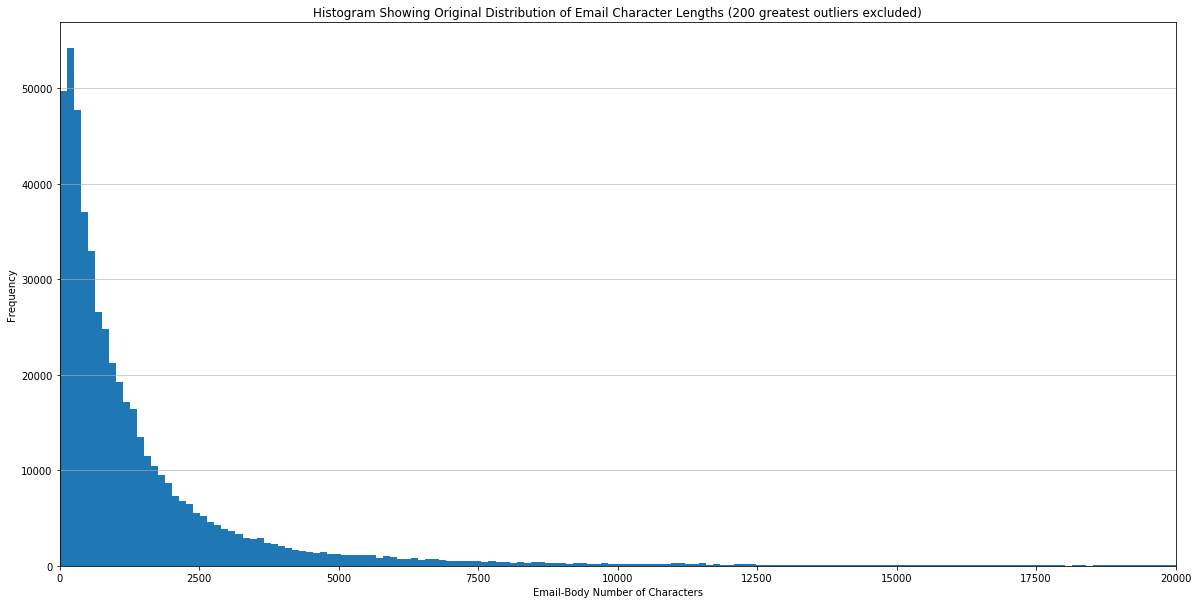

In [10]:
# excludes the most extreme outliers which make the histogram uninterpretable.
plt.figure(figsize=(20,10))
plt.hist(x=doc_lengths[:-200], bins=1000)
plt.grid(axis='y', alpha=0.75)
plt.xlim(0,20000)
plt.xlabel('Email-Body Number of Characters')
plt.ylabel('Frequency')
plt.title('Histogram Showing Original Distribution of Email Character Lengths (200 greatest outliers excluded)')
plt.show()

In [11]:
def pad_text(df, column, limit):

    too_long_indexes = []
    for index, text in enumerate(df[column]):
        if len(text) > limit:
            too_long_indexes.append(index)
            df.set_value(index,column,text[:limit])
    print('There are ' + str(len(too_long_indexes)) + ' bodies of text which have exceeded the \
    character limit of ' + str(limit) + ' characters and have, therefore, been padded.')
    df.index = list(range(len(df)))
    return df

df = pad_text(df, 'Text_body', 1000)

/Users/jamesdutfield/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys


There are 219449 bodies of text which have exceeded the     character limit of 1000 characters and have, therefore, been padded.


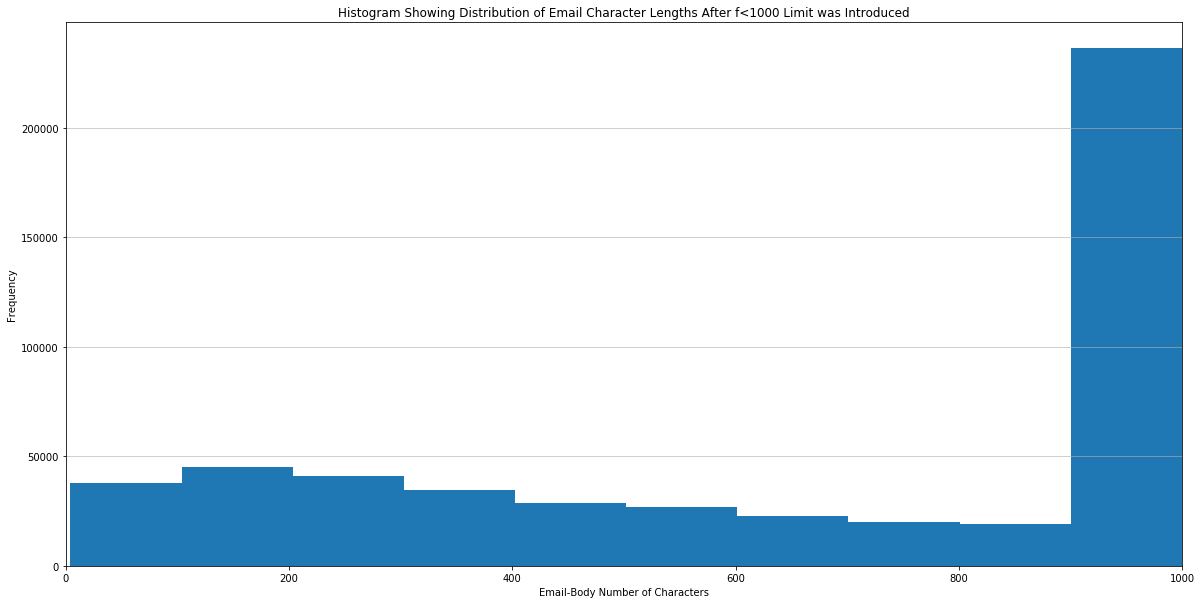

In [12]:
plt.figure(figsize=(20,10))
plt.hist(x=find_doc_lengths(df,'Text_body'), bins=10)
plt.grid(axis='y', alpha=0.75)
plt.xlim(0,1000)
plt.xlabel('Email-Body Number of Characters')
plt.ylabel('Frequency')
plt.title('Histogram Showing Distribution of Email Character Lengths After f<1000 Limit was Introduced')
plt.show()

The cleaning step was moved to after the padding becuase the clean_text function was greatly slowed down by the longer bodies of text.

In [13]:
def clean_text(df, column):
    '''Function takes a dataframe and associated column and removes all punctuation, stopwords and excess spaces\
    from text string. Returns dataframe.'''
    print('Cleaning ' + column + '. Please Wait.')
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    del_number = str.maketrans('', '', digits)
    for i, row in enumerate(df[column]):
        temp = row.lower()
        temp = temp.translate(translator) # remove punctuation
        temp = temp.replace('\t', ' ') # remove \t
        temp = temp.translate(del_number) # remove numbers
        temp = re.sub(' +', ' ',temp) # remove excess spaces
        temp = [word for word in temp.split() if word not in cached_StopWords\
                         and len(word)>1] # remove stopwords and words of length 1. Returns a list.
        df.set_value(i,column,temp)
    print(column + ' is cleaned.')
    return df

In [14]:
df = clean_text(df, 'Text_body')

Cleaning Text_body. Please Wait.


/Users/jamesdutfield/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  from ipykernel import kernelapp as app


Text_body is cleaned.


Applying snowball stemmer to Text_body column. A stemmer was used as it was felt that it would keep information regarding writing style (informal vs formal).

In [15]:
print('Snowball Stemmer is Being Applied to Text Body Column. Please Wait.')
df['stemmed_text'] = df['Text_body'].apply(lambda x: [stemmer.stem(j) for j in x])
print('Complete.')

Snowball Stemmer is Being Applied to Text Body Column. Please Wait.
Complete.


Shuffle dataset. This is necessary becuase the dataset was created in quite a structured form due to the file structure (each user added at a time)

In [16]:
# shuffle dataset (structured by user)
df = df.sample(frac=1).reset_index(drop=True)

In [17]:
df['stemmed_text']

0         [san, diego, updat, recal, lay, say, increas, ...
1         [jp, morgan, futur, sara, sent, schedul, inter...
2         [fw, amend, im, ii, ppa, origin, messag, godfr...
3         [clarif, cargil, issu, document, evid, oper, l...
4         [trv, notif, west, var, report, name, west, va...
                                ...                        
512012                [reuter, press, releas, let, discuss]
512013    [fw, midland, cogener, may, origin, messag, ge...
512014    [transmiss, deal, ap, pinnacl, pinnacl, west, ...
512015    [centana, left, messag, mike, richard, see, co...
512016    [advis, four, season, renov, hmm, hotel, would...
Name: stemmed_text, Length: 512017, dtype: object

Run this cell again to see how different the topics discussed in each email are.


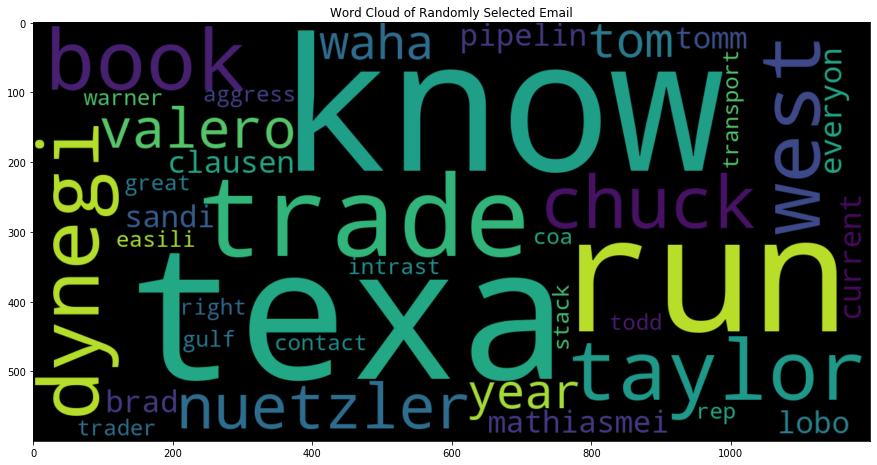

In [18]:
print('Run this cell again to see how different the topics discussed in each email are.')
plt.figure(figsize=(15,10))
plt.title('Word Cloud of Randomly Selected Email')
index = np.random.randint(0,len(df))
X = ' '.join(df['stemmed_text'][index])
wordcloud = WordCloud(width=1200, height=600).generate(X)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

## Section 2: Named Entity Recognition (NER)

This section doesn't contribute to the classifier, however I thought NER would be interesting to research becuase it is a techniques that I hadn't used before.

In [19]:
# text_body at random index
index = np.random.randint(0,len(df))
' '.join(df['Text_body'][index])

'telus gas year oct year oct year oct hope help jon original message dickin mark sent thursday july pm mckay jonathan subject telus gas hi jon discussed thanks help mark file telus convention centre xls'

In [20]:
# Named entities for text_body
doc = nlp(' '.join(df['Text_body'][index]))
d={X.text:X.label_ for X in doc.ents}
d

{'year oct year oct year': 'DATE',
 'jon': 'PERSON',
 'thursday': 'DATE',
 'july': 'DATE',
 'pm mckay': 'ORG'}

In most cases it can be seen the NER is at least partially correct, however it often seems to combine entities or tag them as the incorrect type. Perhaps this would have worked better if conducted before text body was made entirely lower-case so that proper nouns are more obvious.

## Section 3: Getting Labels

In [21]:
def get_domains(df, column):
    '''Function which takes a dataframe and associated column of email addresses and returns dictionary and count\
    of all email domains'''
    company_domains = {}
    for address in df[column]:

        if address == '':
            continue
        
        if ',' in address:
            counter = address.count('@')
            splits = address.split(',')
            for i in splits[:counter]: # if send to multiple people multiple are given
                
                domain = i.split('@')[1]
                domain = '.'.join(domain.split('.')[:-1])
                if domain in company_domains:
                    company_domains[domain] +=1
                else:
                    company_domains[domain] = 1
        else:
            domain = address.split('@')[1]
            domain = '.'.join(domain.split('.')[:-1])
            if domain in company_domains:
                company_domains[domain] +=1
            else:
                company_domains[domain] = 1
    return company_domains

In [22]:
domains_To = get_domains(df, 'To (@)')
domains_From = get_domains(df,'From (@)')
domains_Cc = get_domains(df, 'Cc (@)')
domains_Bc = get_domains(df, 'Bcc (@)')

In [23]:
largest_domains = {}
for i in range(19):
    key = max(domains_From.items(), key=operator.itemgetter(1))[0]
    largest_domains[key] = domains_From[key]
    del domains_From[key]
other = sum(domains_From.values())
largest_domains['other'] = other

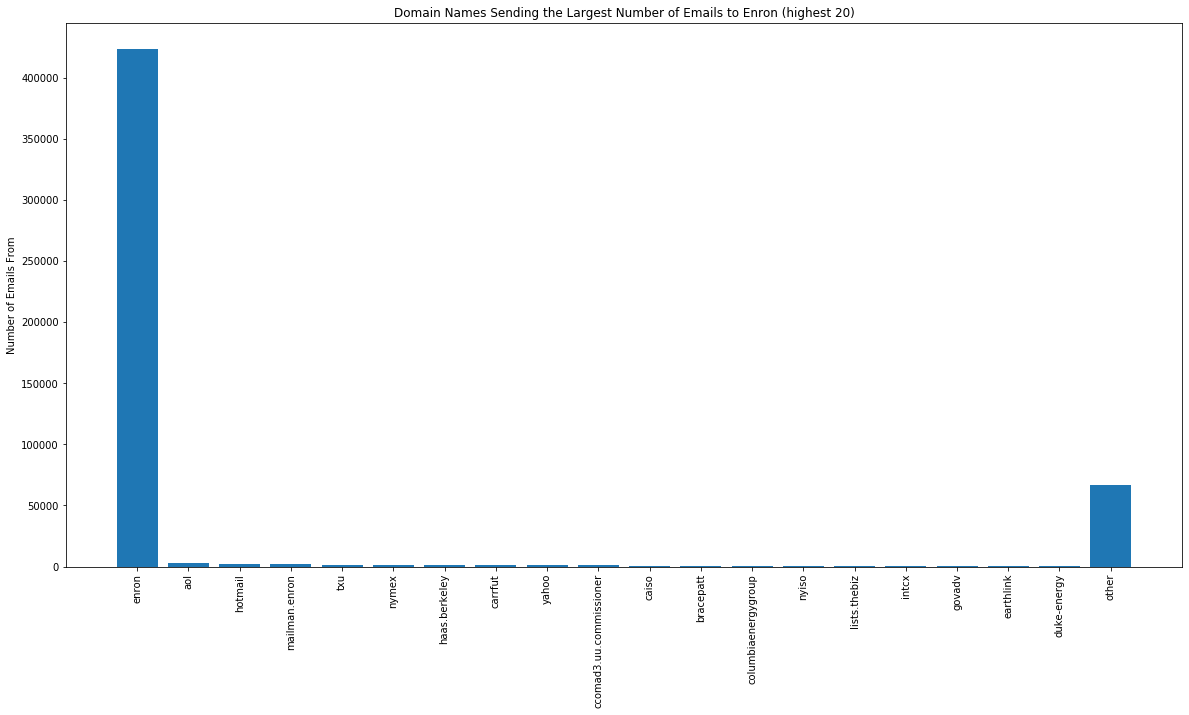

In [24]:
keys = largest_domains.keys()
values = largest_domains.values()

plt.figure(figsize=(20,10))
plt.title('Domain Names Sending the Largest Number of Emails to Enron (highest 20)')
plt.ylabel('Number of Emails From')
plt.xlabel('')
plt.bar(keys, values)
plt.xticks(rotation='vertical')
plt.show()

The information shown in the above graph is slightly concerning for the classifier as it appears as though there is not much communication with outside companies. However bear in mind that this is the number of emails recieved from the domains (the classifier will use looking for 'senders') and it will not be uncommon to cc in a colleague to an outgoing email, which may skew the above.

The below is a function to determine whether each email is completely internal or will be viewed by and external company. Will assign a label of 1 or 0 respectively.

In [25]:
def is_enron(df, column):
    '''Function which takes a dataframe and associated column of email addresses and returns a list of the count\
    at each row of email domains that are @enron and a second list of the count of email addresses that are not @enron '''
    enron = []
    other = []

    for address in df[column]:
        
        enron_count = address.count('enron')
        enron.append(enron_count)
        any_count = address.count('@')
        other.append(any_count - enron_count)
              
    return enron, other

In [26]:
#run function
to_ = is_enron(df,'To (@)')
from_ = is_enron(df,'From (@)')
cc_ = is_enron(df,'Cc (@)')
bcc_ = is_enron(df,'Bcc (@)')

#isolate columns
to_enron_count = to_[0]
to_other_count = to_[1]

from_enron_count = from_[0]
from_other_count = from_[1]

cc_enron_count = cc_[0]
cc_other_count = cc_[1]

bcc_enron_count = bcc_[0]
bcc_other_count = bcc_[1]

Creating labels binary classifier

In [27]:
internal_enron=[]

for i, j, k, m in zip(from_enron_count, to_other_count, cc_other_count, bcc_other_count):
    if i > 0:
        if j > 0 or k > 0 or m > 0:
            internal_enron.append(0) # message is not internal
        else:
            internal_enron.append(1) # message is not internal
    else:
        internal_enron.append('F') # message not sent by enron    

In [28]:
df['internal_enron'] = internal_enron

Data is only required for emails send by Enron employees. Therefore emails from other senders must be removed.

In [29]:
df = df[df.internal_enron != 'F']
df.index = list(range(len(df)))
print('The new dataframe consisting of only emails sent by enron employees is of length: ' + str(len(df)))

The new dataframe consisting of only emails sent by enron employees is of length: 426363


In [30]:
count = 0
for i in df['internal_enron']:
    if i == 1:
        count+=1
print('The number of fully internal enron emails in the dataset is ' + str(count))
print('The number of emails sent to external domains in the dataset is ' + str(len(df)-count))

The number of fully internal enron emails in the dataset is 357823
The number of emails sent to external domains in the dataset is 68540


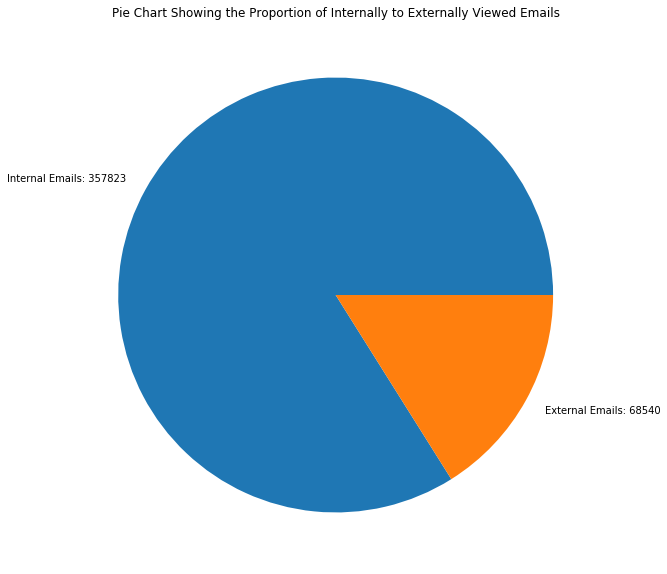

In [31]:
plt.figure(figsize=(20,10))
plt.title('Pie Chart Showing the Proportion of Internally to Externally Viewed Emails')
plt.pie([count, len(df)-count], labels=['Internal Emails: '+str(count), 'External Emails: '+str(len(df)-count)])
plt.show()

The dataset is imbalanced. Oversampling or undersampling could be used to remedy this.

## Section 4: Building Classifier and Analysis



Test dataset (10%) removed before oversampling takes place. This will be used to test the final binary classification model.

In [32]:
test_limit = int(len(df)/10) # 10% of the dataset used for final testing
X_test = np.array(list(df['stemmed_text'][:test_limit]))
y_test = np.array(list(df['internal_enron'][:test_limit]))
df = df[test_limit:]
print('There are ' + str(len(X_test)) + ' items in test dataset.')

There are 42636 items in test dataset.


### Oversampling
I opted to oversample rather than undersample because the remaining dataset is not very large so making it even smaller will negatively effect performance. The minority class (0) was partially duplicated to match the number of values of the majority class (1).

In [33]:
df_1 = df[df.internal_enron == 1]
df_0 = df[df.internal_enron == 0]
oversampling_factor = len(df_1)-len(df_0)
df_0 = pd.concat([df_0,df_0[:oversampling_factor]])

In [34]:
df = pd.concat([df_0, df_1])
df = df.sample(frac=1).reset_index(drop=True) # reshuffle dataframe
print('New length of dataframe is: ' + str(len(df)) + '. It is now a 50:50 split between its label.')

New length of dataframe is: 445367. It is now a 50:50 split between its label.


### Preparation for Neural Network

The remaining data undergos a 80:20 split for training:validation

In [35]:
X = np.array(list(df['stemmed_text']))
y = np.array(list(df['internal_enron']))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((356293,), (89074,), (42636,), (356293,), (89074,), (42636,))

In [36]:
all_words = [word for review in X_train for word in review]
unique_words = set(all_words)
print('There are circa {} unique words in the training dataset'.format(len(unique_words)))

There are circa 104934 unique words in the training dataset


In [37]:
tokenizer = Tokenizer(oov_token='</OOV]\)', num_words=5000) # vocabulary_size = 5000
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [38]:
training_sequences = tokenizer.texts_to_sequences(X_train)
val_sequences = tokenizer.texts_to_sequences(X_val)
test_sequences = tokenizer.texts_to_sequences(X_test)

Determine padding size for sequences. Due to the character padding done earlier there shouldn't be too much padding neccessary.

In [39]:
max_train = max([len(x) for x in training_sequences]) # maximum length for padding
print('Array lengths will be set to: ' + str(max_train))

Array lengths will be set to: 177


In [40]:
X_train = pad_sequences(training_sequences, maxlen=max_train)
X_val = pad_sequences(val_sequences, maxlen=max_train)
X_test = pad_sequences(test_sequences, maxlen=max_train)

In [41]:
# get labels into compatible format
y_train = np.asarray(y_train).astype('float32')
y_val = np.asarray(y_val).astype('float32')
y_test = np.asarray(y_test).astype('float32')

### Compile and Train RNN

This was the best architecture out of the few that I tested. Due to computing/time contraints I didn't conduct a grid_search_cv to optimise. Dropout was added for regularisation which stopped overfitting and allowed the model to train for longer to a higher validation accuracy before the early stopping kicked in.

Trained with mini-batches of batch_size=128.

In [42]:
vocabulary_size = 5001
embedding_dimension = 64

RNN = tf.keras.Sequential([
                                 tf.keras.layers.Embedding(vocabulary_size+1, embedding_dimension, input_length=max_train),
                                 tf.keras.layers.LSTM(64, return_sequences=True, recurrent_dropout=0.2, dropout=0.2),
                                 tf.keras.layers.LSTM(32),
                                 tf.keras.layers.Dropout(0.4),
                                 tf.keras.layers.Dense(64, activation= 'relu'),
                                 tf.keras.layers.Dropout(0.4),
                                 keras.layers.Dense(1, activation = 'sigmoid')
])
RNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [43]:
print(RNN.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 177, 64)           320128    
_________________________________________________________________
lstm (LSTM)                  (None, 177, 64)           33024     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [44]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=3)
RNN_history = RNN.fit(X_train, y_train, epochs=30, batch_size=128,validation_data=(X_val, y_val), callbacks=[es], shuffle=True)

Train on 356293 samples, validate on 89074 samples
Epoch 1/30
356293/356293 [==============================] - 788s 2ms/sample - loss: 0.3694 - accuracy: 0.8363 - val_loss: 0.3186 - val_accuracy: 0.8578
Epoch 2/30
356293/356293 [==============================] - 1333s 4ms/sample - loss: 0.2915 - accuracy: 0.8761 - val_loss: 0.2698 - val_accuracy: 0.8856
Epoch 3/30
356293/356293 [==============================] - 806s 2ms/sample - loss: 0.2480 - accuracy: 0.8964 - val_loss: 0.2345 - val_accuracy: 0.9010
Epoch 4/30
356293/356293 [==============================] - 776s 2ms/sample - loss: 0.2153 - accuracy: 0.9119 - val_loss: 0.2136 - val_accuracy: 0.9127
Epoch 5/30
356293/356293 [==============================] - 771s 2ms/sample - loss: 0.1892 - accuracy: 0.9236 - val_loss: 0.1943 - val_accuracy: 0.9219
Epoch 6/30
356293/356293 [==============================] - 757s 2ms/sample - loss: 0.1687 - accuracy: 0.9335 - val_loss: 0.1766 - val_accuracy: 0.9318
Epoch 7/30
356293/356293 [==========

### Evaluate RNN

The test accuracy roughly matches that of the validation accuracy. Considering that the test sample was separated before the undersampling took place, this proves that there is little loss in performance from using the classifer on a dataset with the actual unbalanced distribution of labels.

It is also interesting that the model performs better on the training dataset when evaluating afterwards compared to during the training process. This is becuase when evaluating afterwards, the dropout is no longer active so the classifier can use the full capability of the neural network. 

In [45]:
train_acc = RNN.evaluate(X_train, y_train)

356293/356293 [==============================] - 340s 954us/sample - loss: 0.0200 - accuracy: 0.9929


In [46]:
val_acc = RNN.evaluate(X_val, y_val)

89074/89074 [==============================] - 85s 949us/sample - loss: 0.1029 - accuracy: 0.9744


The test accuracy roughly matches that of the validation accuracy.

In [47]:
test_acc = RNN.evaluate(X_test, y_test)

42636/42636 [==============================] - 41s 951us/sample - loss: 0.1569 - accuracy: 0.9672


The learning rate graph shows a steady increase in training accuracy and validation accuracy during the training process. The graph shows a slight trend towards overfitting as the validation accuracy stopped improving, so the model was stopped at the correct time.

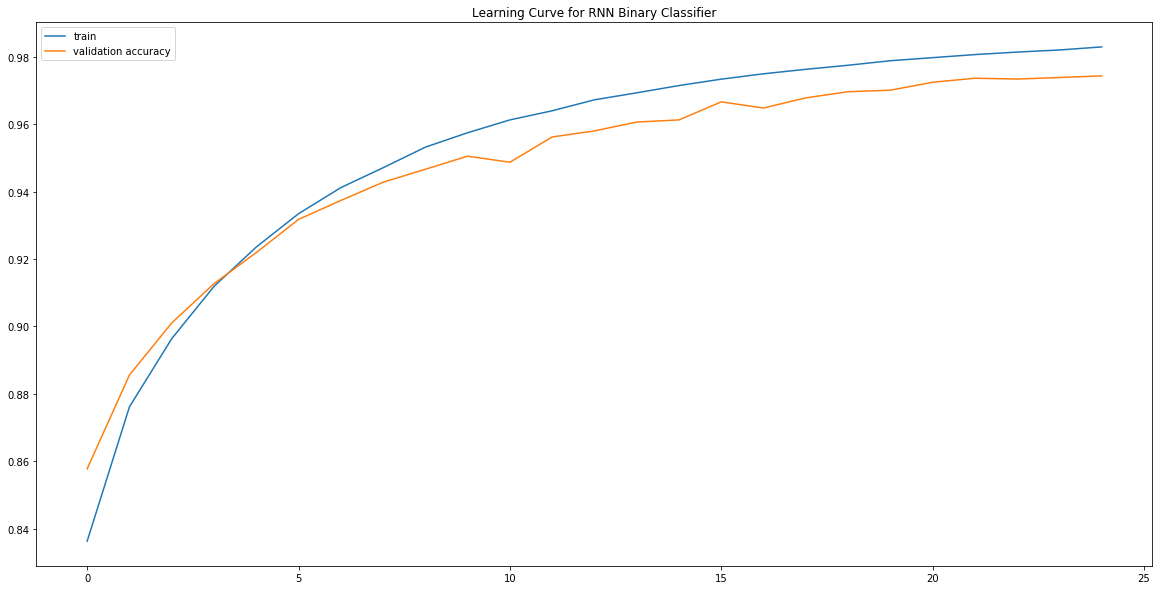

In [48]:
plt.figure(figsize=(20,10))
plt.title('Learning Curve for RNN Binary Classifier')
plt.plot(RNN_history.history['accuracy'], label='train')
plt.plot(RNN_history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

There are a large number of true positives/negatives, and very few false predictions.

In [49]:
test_pred = RNN.predict_classes(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, test_pred).ravel()
tn, fp, fn, tp

(6371, 529, 871, 34865)

In [50]:
print('True Positive Normalised = ' + str(tp/len(y_test)))
print('False Positive Normalised = ' + str(fp/len(y_test)))
print('True Negative Normalised = ' + str(tn/len(y_test)))
print('False Negative Normalised = ' + str(fn/len(y_test)))

True Positive Normalised = 0.8177361853832442
False Positive Normalised = 0.012407355286612253
True Negative Normalised = 0.14942771366919974
False Negative Normalised = 0.020428745660943805


In [57]:
recall = tp/(tp+fn) #true positive rate
specificity = tn/(tn+fp) #true negative rate
precision = tp/(tp+fp)
f1_score = 2*((precision*recall)/(precision+recall))

print('Performance Metrics of Model')
print('Training Accuracy: '+str(train_acc[1]))
print('Test Accuracy: '+str(test_acc[1]))
print('Recall: '+str(recall))
print('Specificity: '+str(specificity))
print('Precision: ' +str(precision))
print('f1_score: '+str(f1_score))

Performance Metrics of Model
Training Accuracy: 0.99288225
Test Accuracy: 0.9671639
Recall: 0.9756268188941124
Specificity: 0.9233333333333333
Precision: 0.9850539639486918
f1_score: 0.9803177281034724


## Section 5: Conclusions

I have never worked with data/text as unstructured as the Enron dataset before, therefore, by far the most time-consuming part of the project was figuring out how to convert the data into a usable form in an efficient way.

The original hypothesis may be correct that an employee at a company will write in a different style when an email is only to be recieved internally by colleagues within the same company vs when an email is to be recieved externally by somebody outside the company. This model does not explain exactly what that difference in writing style or content is, but I expect it is either a difference in how formal they are writing - or perhaps there are certain topics that are only discussed internally that there would be no need to discuss with an outside party (e.g accounting reports).

The next step for this project would be to create small test datasets unique to different authors (e.g arnold-j@enron.com) and see if there is much difference in the confusion matrix for each person. As stated in the introduction, this could be used to flag employees who are overly informal when sending emails to external persons (indicated low specicifity) or internally (indicated by high sensitivity/recall).

Overall, the project can be deemed a success. The final model performed much better than I had expected, with a 0.97 test accuracy and f1 score of 0.98.

## Section 6: Save Model

Save model to JSON file in case I plan to continue project in future. Code written for loading too.

In [59]:
# Save model

# serialize to JSON
RNN_JSON = RNN.to_json()
with open('Enron_RNN.json', 'w') as json_file:
    json_file.write(RNN_JSON)
    
# serialize weights to HDF5
RNN.save_weights('Enron_RNN_weights.h5')
print('RNN Model Saved')

Saved Model


In [66]:
# load model

# load JSON
json_file = open('Enron_RNN.json', 'r')
loaded_RNN_json = json_file.read()
json_file.close()
loaded_RNN = model_from_json(loaded_RNN_json)

# load weights
loaded_RNN.load_weights('Enron_RNN_weights.h5')
print('RNN Model Loaded')

RNN Model Loaded


In [68]:
# combile loaded model
loaded_RNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# test loaded model to check it is the same
loaded_test_acc = loaded_RNN.evaluate(X_test, y_test)

42636/42636 [==============================] - 40s 941us/sample - loss: 0.1569 - accuracy: 0.9672


The loaded model performed to exactly the same accuracy on the test set, therefore the save/load was successful.